In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import datetime, statsmodels, warnings
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf 
warnings.simplefilter("ignore")
from sklearn.metrics import mean_squared_error
from math import sqrt
from dateutil.relativedelta import relativedelta
from datetime import date, timedelta
import ipywidgets as widgets

In [2]:
#Loading the dataset
data = pd.read_excel("Inflation.xls")

In [3]:
# Generate a widget
widget = widgets.IntRangeSlider(value=[1975, 2000], min=1960, max=2020, step=1, description='Time Period:',
                                disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='d')
widget


IntRangeSlider(value=(1975, 2000), description='Time Period:', max=2020, min=1960)

In [4]:
# Prepare Data
years = widget.value
years = list(range(years[0], years[1]+1))
data['Year'] = pd.DatetimeIndex(data['observation_date']).year
data['Month'] = [d.strftime('%b') for d in data.observation_date]
# Draw Plot
fig = go.Figure()
for i, y in enumerate(years):
    if i < len(years):
        fig.add_trace(go.Scatter(
            x=data[data['Year'] == years[i]].Month.tolist(),
            y=data[data['Year'] == years[i]].Monthly_Rate.round(2).tolist(),
            name=str(years[i])))
fig.update_layout(title=go.layout.Title(
    text="Seasonal Trend of Monthly Inflation Rate",
    xref="paper",
    x=0),
    margin=dict(l=10, r=0, t=50, b=50),
    xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(text="Month", font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"))),
    yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(text="Inflation", font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"))))
fig.update_yaxes(nticks=10)

fig.show()


In [5]:
Train = data[data.Year < 1996]
Valid = data[data.Year > 1995]

In [6]:
fig = go.Figure()
fig.add_trace(go.Scatter(dict(x=Train.observation_date, y=Train.Monthly_Rate, mode="lines+markers", name="Train")))
fig.add_trace(go.Scatter(dict(x=Valid.observation_date, y=Valid.Monthly_Rate, mode="lines+markers", name="Valid")))
fig.update_layout(title=go.layout.Title(
    text="Monthly Infaltion Rates for 1960-2020",
    xref="paper", x=0),
    margin=dict(l=10, r=0, t=50, b=50),
    xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(text="Year", font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"))),
    yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(text="Inflation", font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"))))
fig.show()


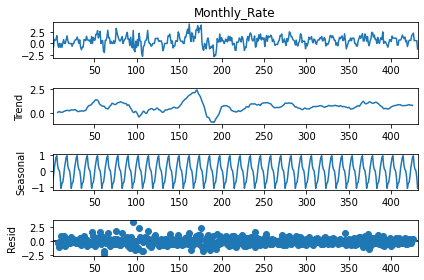

In [15]:
result = seasonal_decompose(Train['Monthly_Rate'].dropna(), model='additive', period=12)
result.plot()
plt.show()


In [17]:
# Defining the check for Data Stationarity using Rolling Mean and Rolling Standard Deviation
def TestStationaryPlot(ts):
    rol_mean = ts.rolling(window=12, center=False).mean()
    rol_std = ts.rolling(window=12, center=False).std()

    fig = go.Figure()
    fig.add_trace(go.Scatter(dict(x=data.observation_date, y=ts, mode='lines+markers', name='Original Data')))
    fig.add_trace(go.Scatter(dict(x=data.observation_date, y=rol_mean, mode='lines',
                  name='Rolling Mean', line=dict(color='black', width=2))))
    fig.add_trace(go.Scatter(dict(x=data.observation_date, y=rol_std, mode='lines',
                  name='Rolling Standard', line=dict(color='brown', width=2))))
    fig.update_layout(title=go.layout.Title(
        text="Rolling Mean & Standard Deviation",
        xref="paper", x=0),
        margin=dict(l=10, r=0, t=50, b=50),
        xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(text="Year", font=dict(
            family="Courier New, monospace",
            size=18,
            color="#7f7f7f"))),
        yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(text="Inflation", font=dict(
            family="Courier New, monospace",
            size=18,
            color="#7f7f7f"))))
    fig.show()  # Defining the check for Data Stationarity using Augmented Dickey Fuller(ADF) test


def adf_test(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='BIC', regression='c')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)


In [18]:
TestStationaryPlot(Train["Monthly_Rate"].dropna(inplace=False))
adf_test(Train["Monthly_Rate"].dropna())


Results of Dickey-Fuller Test:
Test Statistic                -1.127697e+01
p-value                        1.488314e-20
#Lags Used                     0.000000e+00
Number of Observations Used    4.300000e+02
Critical Value (1%)           -3.445649e+00
Critical Value (5%)           -2.868285e+00
Critical Value (10%)          -2.570363e+00
dtype: float64


In [19]:
Train_seasonal_difference = Train["Monthly_Rate"] - Train["Monthly_Rate"].shift(12)
Train_seasonal_first_difference = Train_seasonal_difference - \
    Train_seasonal_difference.shift(1)  # Plotting and testing the time series for stationarity
TestStationaryPlot(Train_seasonal_first_difference.dropna(inplace=False))
adf_test(Train_seasonal_first_difference.dropna(inplace=False))


Results of Dickey-Fuller Test:
Test Statistic                -5.897079e+00
p-value                        2.834797e-07
#Lags Used                     1.100000e+01
Number of Observations Used    4.060000e+02
Critical Value (1%)           -3.446560e+00
Critical Value (5%)           -2.868685e+00
Critical Value (10%)          -2.570576e+00
dtype: float64


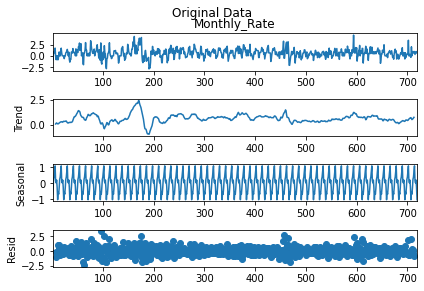

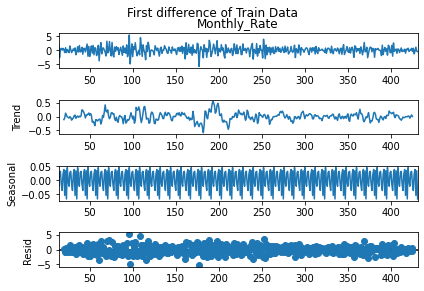

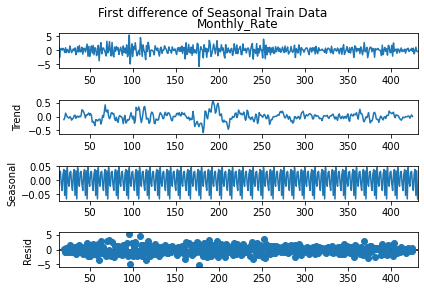

In [21]:
# Seasonal Decomposition
result = seasonal_decompose(data['Monthly_Rate'].dropna(), model='additive', period=12)
result.plot()
plt.suptitle('Original Data', y=1)
plt.show()
result1 = seasonal_decompose(Train_seasonal_first_difference.dropna(), model='additive', period=12)
result1.plot()
plt.suptitle('First difference of Train Data', y=1)
plt.show()
result2 = seasonal_decompose(Train_seasonal_first_difference.dropna(), model='additive', period=12)
result2.plot()
plt.suptitle('First difference of Seasonal Train Data', y=1)
plt.show()


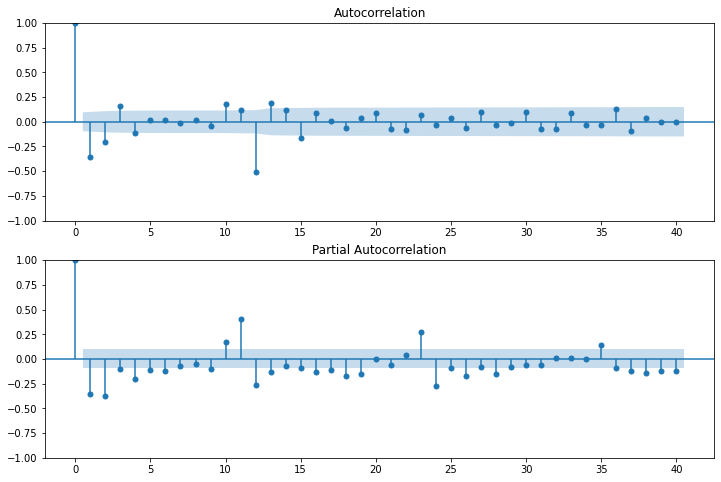

In [22]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)  # Autocorrelation Graph for 40 periods
fig = sm.graphics.tsa.plot_acf(Train_seasonal_first_difference.dropna(), lags=40,
                               ax=ax1)  # Partial autocorrelation Graph for 40 periods
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(Train_seasonal_first_difference.dropna(), lags=40, ax=ax2)


                                      SARIMAX Results                                      
Dep. Variable:                        Monthly_Rate   No. Observations:                  432
Model:             SARIMAX(1, 0, 1)x(1, 1, [], 12)   Log Likelihood                -565.304
Date:                             Sun, 15 May 2022   AIC                           1144.608
Time:                                     16:13:48   BIC                           1172.670
Sample:                                          0   HQIC                          1155.713
                                             - 432                                         
Covariance Type:                               opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
intercept            0.0410      0.071      0.578      0.563      -0.098       0.180
drift    

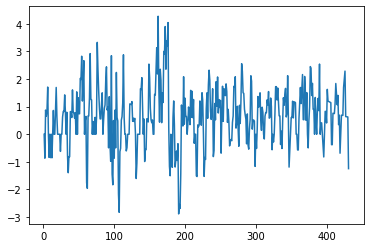

In [52]:
sar = pd.DataFrame(Train["Bank Rate"]) # Introducing a lag of 5 quarters
sar["Bank Rate Lagged"] = sar["Bank Rate"].shift(15)  # Solving for NAN values
sar["Bank Rate Lagged"].fillna(0, inplace=True)  # SARIMAX Model
y_hat_avg = Valid.copy()
fit1 = SARIMAX(Train["Monthly_Rate"], order=(1, 0, 1), seasonal_order=(1, 1, 0, 12), exog=sar["Bank Rate Lagged"],
               trend='ct', simple_differencing=False, enforce_stationarity=False).fit()
print(fit1.summary())


In [24]:
# Preparing Data
start = Valid.index[0]-1  # (=431)
end = Valid.index[-1]+1  # (=721)
x = data.loc[start:, "Bank Rate"]
x = x.shift(15)
x.fillna(0, inplace=True)
pred = pd.DataFrame(x)  # Predicting inflation
y_hat_avg['SARIMAX'] = fit1.predict(start=start, end=end, dynamic=True, exog=pred)


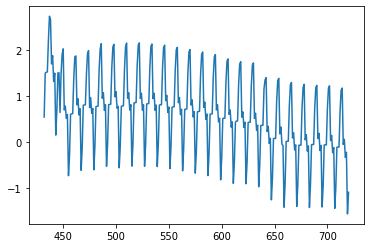

In [25]:
plt.plot(y_hat_avg["SARIMAX"])

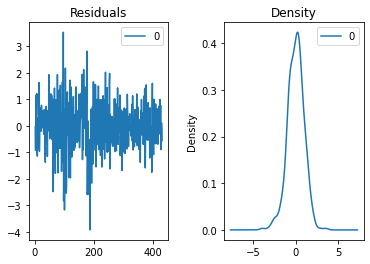

                0
count  431.000000
mean     0.008979
std      0.957880
min     -3.932010
25%     -0.626178
50%      0.067874
75%      0.606186
max      3.532177


In [26]:
# Correcting for NAN values
Valid.Monthly_Rate = np.where(np.isnan(Valid.Monthly_Rate), 0, Valid.Monthly_Rate)
# Root mean square and standard deviation
y_hat_avg.SARIMAX = np.where(np.isnan(y_hat_avg.SARIMAX), 0, y_hat_avg.SARIMAX)
rms = sqrt(mean_squared_error(Valid.Monthly_Rate, y_hat_avg.SARIMAX.dropna()))
std = Valid.Monthly_Rate.std()
error = round(round(rms, 4) - round(std, 4), 4)  # Plotting the residual density and estimating its distribution
residuals = pd.DataFrame(fit1.resid)
fig, ax = plt.subplots(1, 2)
fig.subplots_adjust(hspace=0.3, wspace=0.4)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()
print(residuals.describe())


In [33]:
# Preparing data
date_list = []
start = datetime.datetime(2020, 2, 1)
for x in range(0, 251):
    dates = (start + relativedelta(months=x)).strftime("%Y-%m-%d")
    date_list.append(dates)
col = pd.Series(date_list)
df = pd.DataFrame()
df['observation_date'] = col
data = pd.concat((data, df))
# data.reset_index(inplace=True)
data['Bank Rate'].fillna(0, inplace=True)  # ARIMA Model
fit2 = ARIMA(data["Bank Rate"], order=(1, 0, 0)).fit()
print(fit2.summary())


                               SARIMAX Results                                
Dep. Variable:              Bank Rate   No. Observations:                 2227
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 626.249
Date:                Sun, 15 May 2022   AIC                          -1246.499
Time:                        14:43:57   BIC                          -1229.374
Sample:                             0   HQIC                         -1240.245
                               - 2227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5404      5.299      0.479      0.632      -7.846      12.927
ar.L1          0.9990      0.001    884.088      0.000       0.997       1.001
sigma2         0.0333    7.2e-05    462.314      0.0

In [39]:
# Predicting Bank Rates
pred_uc = fit2.predict(start=721, dynamic=True)
results = pd.Series(pred_uc)
df = pd.DataFrame()
df['Bank Rate'] = results
data.loc[721:, 'Bank Rate'] = df


In [40]:
fit3 = SARIMAX(data["Monthly_Rate"], order=(1, 0, 1),
               seasonal_order=(1, 1, 0, 12), trend='ct', exog=data["Bank Rate"].shift(16).fillna(0), simple_differencing=False, enforce_stationarity=False).fit()


In [44]:
data = data[~data.index.duplicated()]
data[data.index.duplicated()]

,level_0,index,observation_date,Monthly_CPI,Monthly_Inflation,Monthly_Rate,Bank Rate,Year,Month


In [50]:
forecast = fit3.predict(start=722, dynamic=True, exog=df)
inflation = pd.Series(forecast)
inf_rate = pd.DataFrame()
inf_rate['Monthly_Rate'] = inflation
inf_rate = inf_rate[~inf_rate.index.duplicated()]
data.loc[721:, 'Monthly_Rate'] = inf_rate['Monthly_Rate']
